# <span style="color:Purple">ArcGIS Notebook for Transportation Safety: </span>
# <span>Supporting Transportation Safety Road Design with Spatial Analysis and Python</span>

### Transportation engineers tackle the challenges of traffic safety using the Highway Safety Manual Process.

### We introduce GIS analysis concepts into this process, and by using an ArcGIS Notebook to bring spatial analysis and python functionality we can effectively gain the insights that can save lives. 

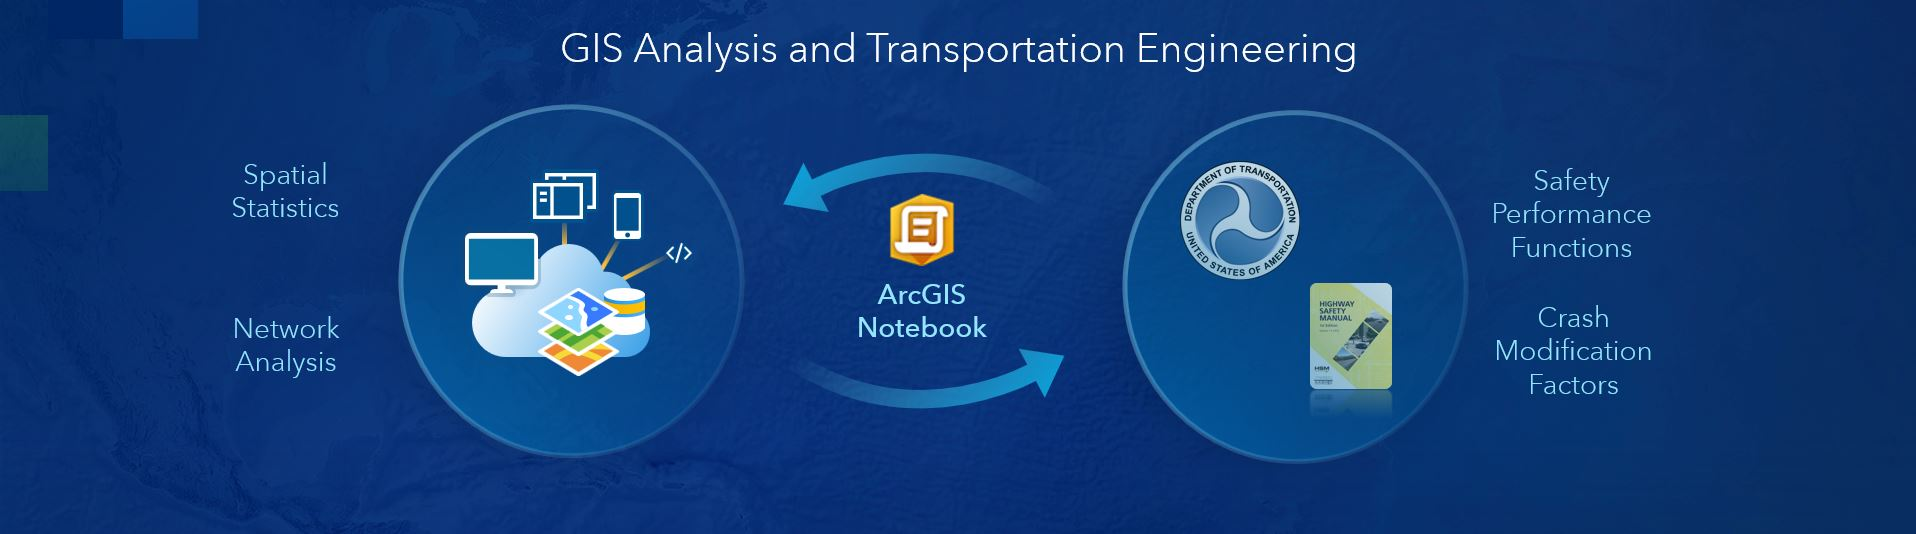

## Import all the tools we need

In [30]:
import arcpy
arcpy.env.overwriteOutput = True
import arcgis
from arcgis import features
import pandas as pd
from arcgis.features import GeoAccessor, GeoSeriesAccessor
from arcgis.geoenrichment import *
from arcgis.geometry import project
from arcgis.mapping import WebMap
import os
import time
import math
import datetime
from IPython.display import display
import numpy as np
import seaborn as sns

## Set our workspace (GIS, workspace directories)

In [2]:
# Set and Change directory to workspace
workspace_dir = r"/arcgis/home/anieto/workspace"
data_dir = r"/arcgis/home/anieto/data"

arcpy.env.overwriteOutput = True
# Create a temporary file geodatabase on disk
if arcpy.Exists(os.path.join(workspace_dir, "maryland_analysis.gdb")):
    workspace_fgdb = os.path.join(workspace_dir, "maryland_analysis.gdb")
else:
    workspace_fgdb = arcpy.CreateFileGDB_management(workspace_dir, "maryland_analysis").getOutput(0)

In [4]:
homegis = arcgis.gis.GIS("home")
gis = arcgis.gis.GIS("https://esrifederal.maps.arcgis.com", username="Anieto_esrifederal", verify_cert=False)

Enter password: ········


In [5]:
if not os.path.isdir("/arcgis/home/anieto"):
    os.mkdir(r"/arcgis/home/anieto")
if not os.path.isdir(r"/arcgis/home/anieto/workspace"):
    os.mkdir(r"/arcgis/home/anieto/workspace")
if not os.path.isdir(r"/arcgis/home/anieto/data"):
    os.mkdir(r"/arcgis/home/anieto/data")

## Bring all the data we need

The following datasets are used for a basic assessment of this workflow:

- **Fatal Accident Crash locations in Maryland (Federal):**
    - Source: NHTSA FARS
    - Extent: Maryland
    - Time: 2002 to 2016
    - Crash Type: Fatal accidents
    - Item: https://esrifederal.maps.arcgis.com/home/item.html?id=89116fe5f52e429f9f2eaace87084739
    - REST Endpoint: https://services.arcgis.com/hRUr1F8lE8Jq2uJo/arcgis/rest/services/FARS_Accidents_in_Maryland_2002_to_2016/FeatureServer


- **Accident Crash locations in Maryland (State):**
    - Source: https://solutions.arcgis.com/local-government/help/crash-analysis/
    - Extent: Maryland
    - Time: 2010 to 2014
    - Crash Type: All types
    - Item: https://esrifederal.maps.arcgis.com/home/item.html?id=89116fe5f52e429f9f2eaace87084739
    - REST Endpoint: https://services.arcgis.com/hRUr1F8lE8Jq2uJo/arcgis/rest/services/FARS_Accidents_in_Maryland_2002_to_2016/FeatureServer


- **Roads: Maryland Interstate Polylines (HPMS AADT Segmentation)**
    - Source: FHWA Highway Performance Management System (HPMS)
    - Extent: Maryland
    - Time: 2016 AADT
    - Includes HPMS Polyline segments derived from AADT for Maryland
    - Item: https://esrifederal.maps.arcgis.com/home/item.html?id=597913c0a2344684896e0c6d1e14040e
    - REST Endpoint: https://services.arcgis.com/hRUr1F8lE8Jq2uJo/arcgis/rest/services/Maryland_Interstates_HPMS/FeatureServer
    

- **Roads: Maryland Interstate Points (0.1 Mile Segmentation)**
    - Source: FHWA Highway Performance Management System (HPMS) and ArcGIS geoprocessing
    - Extent: Maryland
    - Time: 2016 AADT
    - Includes HPMS point segments derived from AADT for Maryland with assigned crash rates from 2016 FARS.
    - Item: https://esrifederal.maps.arcgis.com/home/item.html?id=af6515f1f1ed4ffaa6b5cda3e57aecdd
    - REST Endpoint: https://services.arcgis.com/hRUr1F8lE8Jq2uJo/arcgis/rest/services/HPMS_Point_Segments_Maryland/FeatureServer


- **Analyzed Roads: All Maryland Roads**
    - Source: https://solutions.arcgis.com/local-government/help/crash-analysis/
    - Extent: Maryland
    - Time: 2010 to 2014 AADT
    - Includes HSM/USRAP Crash Rate Risk outputs from Solution Template for all Maryland Roads
    - Item: https://esrifederal.maps.arcgis.com/home/item.html?id=eafe5ab24b2747279b06c220125c4c22
    - REST Endpoint: https://services.arcgis.com/hRUr1F8lE8Jq2uJo/arcgis/rest/services/Maryland_Crash_Rate_Risk/FeatureServer
    

- **Analyzed Roads: Maryland Interstates Result from Crash Analysis Solution**
    - Source: https://solutions.arcgis.com/local-government/help/crash-analysis/
    - Extent: Maryland
    - Time: 2010 to 2014 AADT
    - Includes HSM/USRAP Crash Rate Risk outputs from Solution Template for _just Maryland Interstates_.
    - Item: https://esrifederal.maps.arcgis.com/home/item.html?id=eafe5ab24b2747279b06c220125c4c22
    - REST Endpoint: https://services.arcgis.com/hRUr1F8lE8Jq2uJo/arcgis/rest/services/Maryland_Crash_Rate_Risk/FeatureServer
    
    
    
- **Crash Modification Factors Listings**
    - Source: http://www.cmfclearinghouse.org/index.cfm
    - Extent: Non-spatial data, but applicable to United States
    - Time: Non-temporal data
    - Includes Crash Modification Factor (CMF) listings for safety countermeasures that have been studied. 
    - Item location: '/../data/cmf_listings.xls'
    
    
- **Crash Costs Summary Table**
    - Source: http://www.cmfclearinghouse.org/collateral/ServiceLife_and_CrashCostUserGuide/Crash%20Cost%20Summary%20Table.xlsx
    - Extent: Non-spatial data, but applicable to United States
    - Time: Non-temporal data
    - Includes associated costs with traffic accidents of different types for each state based on studies. 
    - Item location: '/../data/CrashCosts_FHWA.xlsx'

#### >>>> Notebook Data Load Section <<<<

In [6]:
crashes_fars_item = gis.content.search("Traffic Accidents in Maryland 2002 to 2016", item_type="Feature Service")[0]
crashes_maryland_item = gis.content.search("Maryland Crash Locations Light", item_type="Feature Service")[0]
roads_maryland_interstate_polylines_item = gis.content.search("Maryland_Interstates_HPMS", item_type="Feature Service")[-1]
routes_maryland_baseline_item = gis.content.search("Maryland_Routes_Baseline", item_type="Feature Service")[0]
routes_fhwans_mvtcrashes_item = gis.content.search("Routes_wFHWACrashRate_forMVTFatalCrashes", item_type="Feature Service")[0]
routes_fhwans_pedestriancrashes_item = gis.content.search("Routes_wFHWACrashRate_forPedestrianFatalCrashes", item_type="Feature Service")[0]
routes_fhwans_treecrashes_item = gis.content.search("Routes_wFHWACrashRate_forTreeFatalCrashes", item_type="Feature Service")[0]
mvt_item = homegis.content.search("mvt_segments", item_type="Feature Service")[0]
loss4_mvt_item = homegis.content.search("lossIV_mvt", item_type="Feature Service")[0]
ped_item = homegis.content.search("ped_segments", item_type="Feature Service")[0]
loss4_ped_item = homegis.content.search("lossIV_ped", item_type="Feature Service")[0]
tree_item = homegis.content.search("tree_segments", item_type="Feature Service")[0]
loss4_tree_item = homegis.content.search("lossIV_tree", item_type="Feature Service")[0]
cmf_xls = r'/arcgis/home/anieto/data/cmf_listings.xls'
cmf_df = pd.read_excel(cmf_xls)

In [8]:
# CMF Clearinghouse base URL
cmf_base_webpage = "http://www.cmfclearinghouse.org/detail.cfm?facid={0}"
countermeasures_webpage_field = "CMF Webpage"
countermeasures_id_field = "CMF ID"

# Helper function to retrieve the countermeasure summary information
def get_cmf_webpage_from_id(countermeasure_id, cmf_base_webpage=cmf_base_webpage):
    webpage = cmf_base_webpage.format(str(countermeasure_id))
    return webpage

cmf_df[countermeasures_webpage_field] = cmf_df.apply(lambda x: get_cmf_webpage_from_id(x[countermeasures_id_field]), axis=1)

In [9]:
cmf_df.head()

,CMF ID,Study Title,Countermeasure Category,Countermeasure Subcategory,Countermeasure,CRF,CMF,Crash Type,KABCO Crash Severity,Roadway Type,...,Number of Lanes,Intersection Type,Intersection Geometry,Traffic Control Type,Speed Limit (mph),Crash Time of Day,Roadway Division Type,Date CMF Added to Clearinghouse,Public Comments,CMF Webpage
0,1,Lane Width and Safety,Roadway,Lane width,Decrease lane width from 11 feet to 9 feet,-21.0,1.21,All,All,Not specified,...,2,NaN,NaN,NaN,NaN,NaN,NaN,2009-12-01,NaN,http://www.cmfclearinghouse.org/detail.cfm?fac...
1,2,Lane Width and Safety,Roadway,Lane width,Decrease lane width from 11 feet to 10 feet,-9.0,1.09,All,All,Not specified,...,2,NaN,NaN,NaN,NaN,NaN,NaN,2009-12-01,NaN,http://www.cmfclearinghouse.org/detail.cfm?fac...
2,3,Lane Width and Safety,Roadway,Lane width,Increase lane width from 11 feet to 12 feet,5.0,0.95,All,All,Not specified,...,2,NaN,NaN,NaN,NaN,NaN,NaN,2009-12-01,NaN,http://www.cmfclearinghouse.org/detail.cfm?fac...
3,4,Safety Effects of Using Narrow Lanes and Shoul...,Roadway,Number of lanes,Four to five lane conversion,-11.0,1.11,All,All,Principal Arterial Other Freeways and Expressways,...,4 (one direction),NaN,NaN,NaN,NaN,NaN,NaN,2009-12-01,AADT is one direction,http://www.cmfclearinghouse.org/detail.cfm?fac...
4,5,Safety Effects of Using Narrow Lanes and Shoul...,Roadway,Number of lanes,Four to five lane conversion,-10.0,1.10,All,"A (serious injury),B (minor injury),C (possibl...",Principal Arterial Other Freeways and Expressways,...,4 (one direction),NaN,NaN,NaN,NaN,NaN,NaN,2009-12-01,AADT is one direction,http://www.cmfclearinghouse.org/detail.cfm?fac...


In [10]:
mvt_df = pd.DataFrame.spatial.from_layer(mvt_item.layers[0])
mvt_df['Cause'] = "Motor Vehicle in Transport"
ped_df = pd.DataFrame.spatial.from_layer(ped_item.layers[0])
ped_df['Cause'] = "Pedestrians"
tree_df = pd.DataFrame.spatial.from_layer(tree_item.layers[0])
tree_df['Cause'] = "Tree (Standing Only)"

all_segments_df = pd.concat([mvt_df, ped_df, tree_df], sort=True)

In [11]:
all_segments_df.head()

,Cause,SHAPE,cluster_id,crash_type,has_access_control_x,has_access_control_y,has_full_access_control,has_partial_access_control,is_divided_x,is_divided_y,...,segmentoutput_usrap_lanes_y,segmentoutput_usrap_median,segmentoutput_usrap_roadway_typ,segmentoutput_usrap_segid,segmentoutput_usrap_segment,segmentoutput_usrap_speed_lim_1,segmentoutput_usrap_speed_limit,shape__length,source_id,state
0,Motor Vehicle in Transport,"{""paths"": [[[-8535189.390380654, 4708405.38595...",2,NaN,0,0,0,0,0,0,...,2,Undivided Roadway,Rural two-lane Undivided,3706,YES,30,30,14036.632378,1,NaN
1,Motor Vehicle in Transport,"{""paths"": [[[-8734067.66841805, 4818548.890672...",2,NaN,0,0,0,0,0,0,...,2,Undivided Roadway,Rural two-lane Undivided,2957,YES,50,50,50180.354353,2,NaN
2,Motor Vehicle in Transport,"{""paths"": [[[-8523548.943160398, 4711173.13288...",1,NaN,0,0,0,0,0,0,...,4,Undivided Roadway,Urban Multilane Undivided,4639,YES,55,55,5382.565994,9,NaN
3,Motor Vehicle in Transport,"{""paths"": [[[-8522975.651290474, 4740495.85536...",1,NaN,0,0,0,0,0,0,...,2,Undivided Roadway,Urban two-lane Undivided,4109,YES,30,30,12463.020777,3,NaN
4,Motor Vehicle in Transport,"{""paths"": [[[-8781234.53060292, 4798551.281663...",2,NaN,0,0,0,0,0,0,...,3,Undivided Roadway,Rural Multilane Undivided,5393,YES,55,55,14256.729941,4,NaN


In [12]:
loss4_mvt_df = pd.DataFrame.spatial.from_layer(loss4_mvt_item.layers[0])
loss4_mvt_df['Cause'] = "Motor Vehicle in Transport"
loss4_ped_df = pd.DataFrame.spatial.from_layer(loss4_ped_item.layers[0])
loss4_ped_df['Cause'] = "Pedestrians"
loss4_tree_df = pd.DataFrame.spatial.from_layer(loss4_tree_item.layers[0])
loss4_tree_df['Cause'] = "Tree (Standing Only)"

In [13]:
lossIV_dfs_list = [loss4_mvt_df, loss4_ped_df, loss4_tree_df]
for lossIV_df in lossIV_dfs_list:
    if 'State' not in lossIV_df.columns.tolist():
        lossIV_df['State'] = 'MD'
        
loss4_mvt_df['Crash_Type'] = "Motor Vehicle in Transport"
loss4_ped_df['Crash_Type'] = "Pedestrian"
loss4_tree_df['Crash_Type'] = "Tree (Standing Only)"        

#### >>>> End Notebook Data Load Section <<<<

<Item title:"Traffic Accidents in Maryland 2002 to 2016" type:Feature Layer Collection owner:albe9057@esri.com_esrifederal>
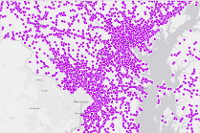

<Item title:"Maryland Crash Locations_Light" type:Feature Layer Collection owner:albe9057@esri.com_esrifederal>
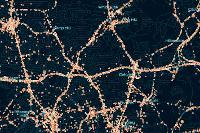

<Item title:"Maryland_Interstates_HPMS" type:Feature Layer Collection owner:albe9057@esri.com_esrifederal>
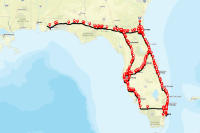

<Item title:"Maryland_Routes_Baseline" type:Feature Layer Collection owner:albe9057@esri.com_esrifederal>
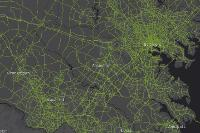

<Item title:"Routes_wFHWACrashRate_forPedestrianFatalCrashes" type:Feature Layer Collection owner:albe9057@esri.com_esrifederal>
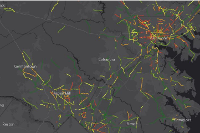

<Item title:"Routes_wFHWACrashRate_forTreeFatalCrashes" type:Feature Layer Collection owner:albe9057@esri.com_esrifederal>
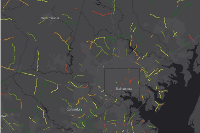

<Item title:"lossIV_mvt" type:Feature Layer Collection owner:anieto>
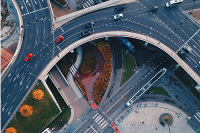

<Item title:"lossIV_ped" type:Feature Layer Collection owner:anieto>
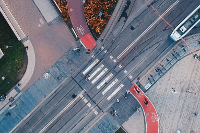

<Item title:"lossIV_tree" type:Feature Layer Collection owner:anieto>
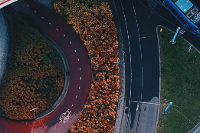

In [14]:
for item in [crashes_fars_item, 
             crashes_maryland_item, 
             roads_maryland_interstate_polylines_item, 
             routes_maryland_baseline_item,  
             routes_fhwans_pedestriancrashes_item, 
             routes_fhwans_treecrashes_item,
             loss4_mvt_item,
             loss4_ped_item,
             loss4_tree_item
             ]:
    display(item)

### First, we'll import and clean up our data

In [15]:
crashes_map = gis.map("Maryland")
crashes_map.add_layer(crashes_fars_item)
crashes_map.basemap = 'gray'
crashes_map

MapView(layout=Layout(height='400px', width='100%'))

In [16]:
needed_fields = [
    "SHAPE",
    "STATE",
    "COUNTY",
    "PERSONS",
    "PEDS",
    "ROAD_FNC",
    "HARM_EV", 
    "MAN_COLL", # Manner of collision (i.e. rear-end)
    "REL_ROAD", # Relation to road (i.e. On roadway, shoulder)
    "LGT_COND", # Light condition (i.e. Daylight, dark)
    "WEATHER", 
    "WEATHER1",
    "WEATHER2",
    "WRK_ZONE",
    "FATALS",
    "DAY_WEEK",
    "DRUNK_DR",
    "TWAY_ID",
    "RAIL",
    "latitude",
    "LONGITUDE",
    "A_RU", # Land use (i.e. Rural/Urban)
    "A_RD", # Involving a roadway departure
    "A_CT", # Crash type
    "A_LT", # Involving a large truck
    "A_MC", # Involving a motorcycle
    "A_SPCRA", # Involving speeding
    "A_PED", # Involving a pedestrian
    "A_PEDAL", # Involving a pedalcyclist
    "A_ROLL", # Involving a rollover
    "A_POLPUR", # Involving a police pursuit
    "A_POSBAC", # Involving a driver with a positive BAC test result
    "A_D15_19", # Crashes Involving a Young Driver (Aged 15-19)
    "A_D15_20", # Crashes Involving a Young Driver (Aged 15-20)
    "A_D16_19", # Crashes Involving a Young Driver (Aged 16-19)
    "A_D16_20", # Crashes Involving a Young Driver (Aged 16-20)
    "A_D16_24", # Crashes Involving a Young Driver (Aged 16-24)
    "A_D21_24", # Crashes Involving a Young Driver (Aged 21-24)
    "A_D65PLS", # Crashes Involving an Older Driver (Aged 65+)
    "A_DIST", # Involving a distracted driver
    "A_DROWSY", # Involving a drowsy driver
    "YEAR_TEXT",
    "MONTH_TEXT",
    "DAY_TEXT",
    "HOUR_TEXT",
    "MINUTE_TEXT",
    "DATE",
    "DATETIME_2",
]

In [17]:
cmf_df.head(12)

,CMF ID,Study Title,Countermeasure Category,Countermeasure Subcategory,Countermeasure,CRF,CMF,Crash Type,KABCO Crash Severity,Roadway Type,...,Number of Lanes,Intersection Type,Intersection Geometry,Traffic Control Type,Speed Limit (mph),Crash Time of Day,Roadway Division Type,Date CMF Added to Clearinghouse,Public Comments,CMF Webpage
0,1,Lane Width and Safety,Roadway,Lane width,Decrease lane width from 11 feet to 9 feet,-21.0,1.21,All,All,Not specified,...,2,NaN,NaN,NaN,NaN,NaN,NaN,2009-12-01,NaN,http://www.cmfclearinghouse.org/detail.cfm?fac...
1,2,Lane Width and Safety,Roadway,Lane width,Decrease lane width from 11 feet to 10 feet,-9.0,1.09,All,All,Not specified,...,2,NaN,NaN,NaN,NaN,NaN,NaN,2009-12-01,NaN,http://www.cmfclearinghouse.org/detail.cfm?fac...
2,3,Lane Width and Safety,Roadway,Lane width,Increase lane width from 11 feet to 12 feet,5.0,0.95,All,All,Not specified,...,2,NaN,NaN,NaN,NaN,NaN,NaN,2009-12-01,NaN,http://www.cmfclearinghouse.org/detail.cfm?fac...
3,4,Safety Effects of Using Narrow Lanes and Shoul...,Roadway,Number of lanes,Four to five lane conversion,-11.0,1.11,All,All,Principal Arterial Other Freeways and Expressways,...,4 (one direction),NaN,NaN,NaN,NaN,NaN,NaN,2009-12-01,AADT is one direction,http://www.cmfclearinghouse.org/detail.cfm?fac...
4,5,Safety Effects of Using Narrow Lanes and Shoul...,Roadway,Number of lanes,Four to five lane conversion,-10.0,1.10,All,"A (serious injury),B (minor injury),C (possibl...",Principal Arterial Other Freeways and Expressways,...,4 (one direction),NaN,NaN,NaN,NaN,NaN,NaN,2009-12-01,AADT is one direction,http://www.cmfclearinghouse.org/detail.cfm?fac...
5,6,Safety Effects of Using Narrow Lanes and Shoul...,Roadway,Number of lanes,Four to five lane conversion,-11.0,1.11,All,"K (fatal),A (serious injury),B (minor injury),...",Principal Arterial Other Freeways and Expressways,...,4 (one direction),NaN,NaN,NaN,NaN,NaN,NaN,2009-12-01,AADT is one direction,http://www.cmfclearinghouse.org/detail.cfm?fac...
6,7,Safety Effects of Using Narrow Lanes and Shoul...,Roadway,Number of lanes,Five to six lane conversion,-3.0,1.03,All,All,Principal Arterial Other Freeways and Expressways,...,5 (one way),NaN,NaN,NaN,NaN,NaN,NaN,2009-12-01,AADT is one direction,http://www.cmfclearinghouse.org/detail.cfm?fac...
7,8,Safety Effects of Using Narrow Lanes and Shoul...,Roadway,Number of lanes,Five to six lane conversion,-4.0,1.04,All,"A (serious injury),B (minor injury),C (possibl...",Principal Arterial Other Freeways and Expressways,...,5 (one way),NaN,NaN,NaN,NaN,NaN,NaN,2009-12-01,AADT is one direction,http://www.cmfclearinghouse.org/detail.cfm?fac...
8,9,Safety Effects of Using Narrow Lanes and Shoul...,Roadway,Number of lanes,Five to six lane conversion,-7.0,1.07,All,"K (fatal),A (serious injury),B (minor injury),...",Principal Arterial Other Freeways and Expressways,...,5 (one way),NaN,NaN,NaN,NaN,NaN,NaN,2009-12-01,AADT is one direction,http://www.cmfclearinghouse.org/detail.cfm?fac...
9,10,Highway Safety Manual Knowledge Document,Shoulder treatments,Shoulder width,Widen paved shoulder from 3 ft to 4 ft,3.0,0.97,All,All,Not specified,...,2,NaN,NaN,NaN,NaN,NaN,NaN,2009-12-01,NaN,http://www.cmfclearinghouse.org/detail.cfm?fac...


In [18]:
harm_ev_lookup_dict = {
    "1": "Rollover/Overturn",
    "2": "Fire/Explosion",
    "3": "Immersion",
    "4": "Gas Inhalation",
    "5": "Fell/Jumped from Vehicle",
    "6": "Injured in Vehicle",
    "7": "Other Non-Collision",
    "8": "Pedestrian",
    "9": "Pedalcyclist",
    "10": "Railway Vehicle",
    "11": "Live Animal",
    "12": "Motor Vehicle in Transport",
    "13": "Motor Vehicle in Transport on Other Roadway",
    "14": "Parked Motor Vehicle (Not in Transport)",
    "15": "Non-Motorist on Personal Conveyance",
    "16": "Thrown or Falling Object",
    "17": "Boulder",
    "18": "Other Object (Not Fixed)",
    "19": "Building",
    "20": "Impact Attenuator/Crash Cushion",
    "21": "Bridge Pier or Support",
    "22": "Bridge Parapet End",
    "23": "Bridge Rail",
    "24": "Guardrail Face",
    "25": "Concrete Traffic Barrier",
    "26": "Other Traffic Barrier",
    "27": "Highway/Traffic Sign Post",
    "28": "Overhead Sign Support/Sign",
    "29": "Luminary/Light Support",
    "30": "Utility Pole/Light Support",
    "31": "Post, Pole, or Other Supports",
    "32": "Culvert",
    "33": "Curb",
    "34": "Ditch",
    "35": "Embankment",
    "36": "Embankment - Rock, Stone, or Concrete",
    "37": "Embankment - Material Type Unknown",
    "38": "Fence",
    "39": "Wall",
    "40": "Fire Hydrant",
    "41": "Shrubbery",
    "42": "Tree (Standing Only)",
    "43": "Other Fixed Object",
    "44": "Pavement Surface Irregularity (Ruts, Potholes, Grates, etc.)",
    "45": "Working Motor Vehicle",
    "46": "Traffic Signal Support",
    "47": "Vehicle Occupant Struck or Run Over by Own Vehicle",
    "48": "Snow Bank",
    "49": "Ridden Animal or Animal-Drawn Conveyance",
    "50": "Bridge Overhead Structure",
    "51": "Jackknife",
    "52": "Guardrail End",
    "53": "Mail Box",
    "54": "Motor Vehicle In-Transport Strikes or is Struck by Cargo, Persons or Objects Set-in-Motion from/by Another Motor Vehicle In-Transport",
    "55": "Motor Vehicle in Motion Outside the Trafficway",
    "57": "Cable Barrier",
    "58": "Ground",
    "59": "Traffic Sign Support",
    "72": "Cargo/Equipment Loss or Shift (Harmful to This Vehicle)",
    "73": "Object Had Fallen From Motor Vehicle In-Transport",
    "74": "Road Vehicle on Rails",
    "91": "Unknown Object Not Fixed",
    "93": "Unknown Fixed Object",
    "98": "Not Reported (2010 Only)",
    "99": "Unknown",
    "100": "NA",
    "101": "NA2"
}

def get_crash_cause_text(code):
    if not isinstance(code, str):
        code = str(code)
    if code not in harm_ev_lookup_dict:
        return "Unknown (Code: {0})".format(str(code))
    return harm_ev_lookup_dict[code]

In [19]:
crashes_fars_sedf['Cause'] = crashes_fars_sedf.apply(lambda x: get_crash_cause_text(x['HARM_EV']), axis=1)
crashes_fars_sedf.head(5)

,SHAPE,STATE,COUNTY,PERSONS,PEDS,ROAD_FNC,HARM_EV,MAN_COLL,REL_ROAD,LGT_COND,...,A_DIST,A_DROWSY,YEAR_TEXT,MONTH_TEXT,DAY_TEXT,HOUR_TEXT,MINUTE_TEXT,DATE,DATETIME_2,Cause
0,"{""x"": -8472633.74400213, ""y"": 4804875.96584184...",24,25,4,1,1,12,1,1,1,...,1,2,2003,1,2,18,38,2003-01-02,2003-01-02 18:38:00,Motor Vehicle in Transport
1,"{""x"": -8492172.788118284, ""y"": 4788736.1271743...",24,25,2,1,11,8,0,1,2,...,2,2,2003,1,3,1,0,2003-01-03,2003-01-03 01:00:00,Pedestrian
2,"{""x"": -8590104.873420665, ""y"": 4773300.4701861...",24,13,1,0,1,37,0,6,2,...,2,2,2003,1,3,22,3,2003-01-03,2003-01-03 22:03:00,Embankment - Material Type Unknown
3,"{""x"": -8531419.711457718, ""y"": 4800227.6152805...",24,5,1,0,6,34,0,6,9,...,2,2,2003,1,4,13,7,2003-01-04,2003-01-04 13:07:00,Ditch
4,"{""x"": -8550156.018425096, ""y"": 4707076.2290324...",24,33,3,0,13,1,0,1,3,...,2,2,2003,1,4,22,30,2003-01-04,2003-01-04 22:30:00,Rollover/Overturn


# <span style="color:Purple">Step 1 Establish Accident Type Focus</span>
## <span>A) Load and Clean Accident Data</span>
## <span>B) Use GIS Analysis to Measure Geographic Distribution (Clustering, Standard Distance) of Accident Types</span>

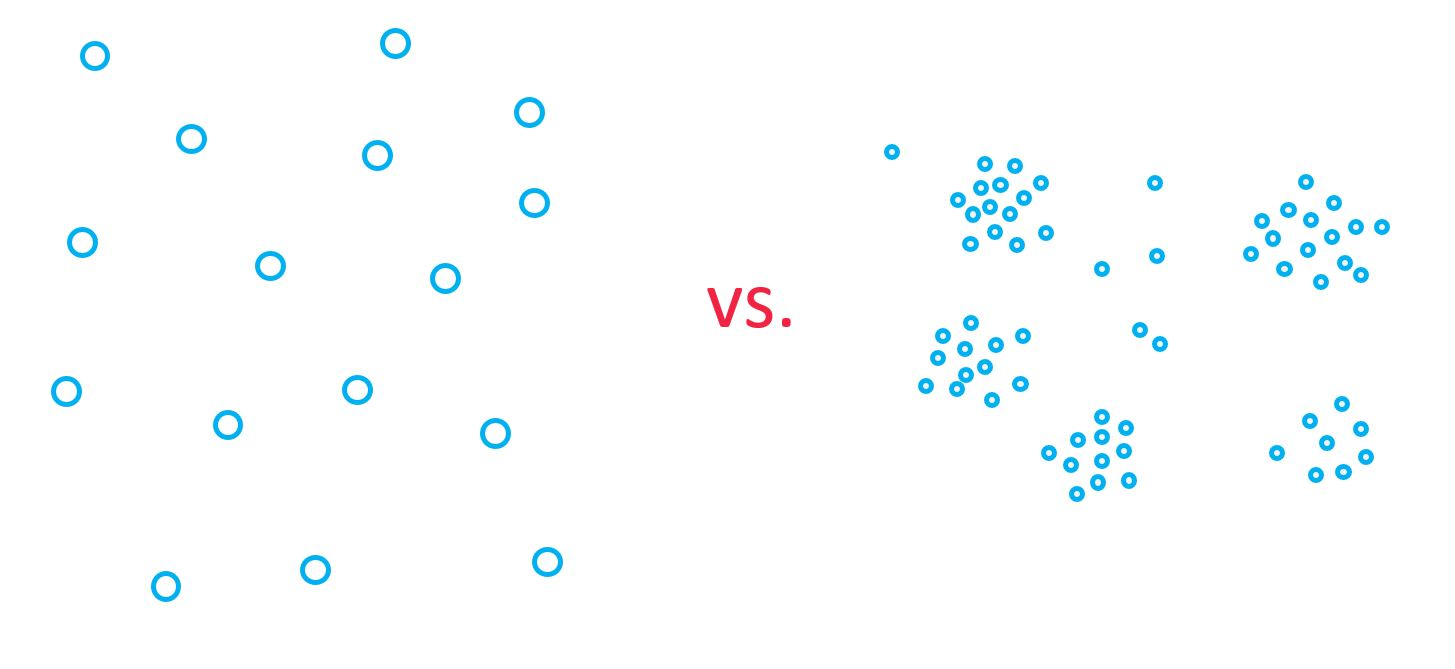

### Proposal: Spatial distribution is closely tied with how addressable each type of crash is. 

### To measure the distribution for each type of accident in Maryland, we'll set up a sequence that runs Density-based Clustering and Standard Distance for each type of accident.

Measures the degree to which features are concentrated or dispersed around the geometric mean center. The standard distance is a useful statistic as it provides a single summary measure of feature distribution around their center (similar to the way a standard deviation measures the distribution of data values around the statistical mean).

In [29]:
crash_type_summary_stats = pd.read_csv(os.path.join(workspace_dir, "crash_type_summary_stats.csv"))

data = crashes_fars_sedf
type_field = "Cause"

top_types_dict = {
    "Rank_1":{},
    "Rank_2":{},
    "Rank_3":{},
    "Rank_4":{},
    "Rank_5":{},
}

print("Producing layers for most clustered accident types...")

top_causes = crash_type_summary_stats.sort_values(by='Std. Distance Mean').head()['Cause'].tolist()

# Produce data for the top five most clustered accident types
for ix, top_cause in enumerate(top_causes):
    print("\nStep {0} of {1}: Measuring spatial distribution of '{2}' accidents...".format(str(ix+1), 
                                                                                           str(len(top_causes)), 
                                                                                           top_cause))
    cause_df = data.loc[data[type_field] == top_cause]
    
    crashes_fc = cause_df.spatial.to_featureclass(os.path.join(workspace_fgdb, "ranked{0}_acctype_fc".format(str(ix+1))))

    # Run Density-based Clustering
    print("\tRunning Density-based Clustering (HDBSCAN with 3 minimum features per cluster)...".format(str(ix+1)))
    output_clusters_path = "{0}//{1}_HDBSCAN".format(workspace_fgdb, "ranked{0}_acctype_hdbscan_fc".format(str(ix+1)))
    hdbscan_result = arcpy.stats.DensityBasedClustering(crashes_fc, output_clusters_path, "HDBSCAN", 5)
    hdbscan_sedf = pd.DataFrame.spatial.from_featureclass(hdbscan_result.getOutput(0))

    cluster_count = hdbscan_sedf[hdbscan_sedf['CLUSTER_ID']!=-1].shape[0]
    noise_count = hdbscan_sedf[hdbscan_sedf['CLUSTER_ID']==-1].shape[0]


    # Parse out accidents that were members of a cluster and write to feature class
    clusters_fc = hdbscan_sedf[hdbscan_sedf['CLUSTER_ID']!=-1].spatial.to_featureclass(os.path.join(workspace_fgdb, "ranked{0}_acctype_clusters_fc".format(str(ix+1))))

    print("\tRunning Standard Distance measurement...")
    output_stddistance_path = "{0}//{1}".format(workspace_fgdb, "ranked{0}_acctype_stddistance_fc".format(str(ix+1)))
    stddistance_result = arcpy.stats.StandardDistance(clusters_fc, output_stddistance_path, Case_Field='CLUSTER_ID')
    stddistance_sedf = pd.DataFrame.spatial.from_featureclass(stddistance_result.getOutput(0))
    
    top_types_dict["Rank_{0}".format(str(ix+1))]["cause_name"] = top_cause
    top_types_dict["Rank_{0}".format(str(ix+1))]["accidents_df"] = cause_df
    top_types_dict["Rank_{0}".format(str(ix+1))]["accidents_fc"] = crashes_fc
    top_types_dict["Rank_{0}".format(str(ix+1))]["hdbscan_df"] = hdbscan_sedf
    top_types_dict["Rank_{0}".format(str(ix+1))]["clustered_df"] = hdbscan_sedf[hdbscan_sedf['CLUSTER_ID']!=-1]
    top_types_dict["Rank_{0}".format(str(ix+1))]["noise_df"] = hdbscan_sedf[hdbscan_sedf['CLUSTER_ID']!=-1]
    top_types_dict["Rank_{0}".format(str(ix+1))]["stddistance_circles_df"] = stddistance_sedf

Producing layers for most clustered accident types...

Step 1 of 5: Measuring spatial distribution of 'Motor Vehicle in Transport' accidents...
	Running Density-based Clustering (HDBSCAN with 3 minimum features per cluster)...
	Running Standard Distance measurement...

Step 2 of 5: Measuring spatial distribution of 'Pedestrian' accidents...
	Running Density-based Clustering (HDBSCAN with 3 minimum features per cluster)...
	Running Standard Distance measurement...

Step 3 of 5: Measuring spatial distribution of 'Tree (Standing Only)' accidents...
	Running Density-based Clustering (HDBSCAN with 3 minimum features per cluster)...
	Running Standard Distance measurement...

Step 4 of 5: Measuring spatial distribution of 'Guardrail Face' accidents...
	Running Density-based Clustering (HDBSCAN with 3 minimum features per cluster)...
	Running Standard Distance measurement...

Step 5 of 5: Measuring spatial distribution of 'Parked Motor Vehicle (Not in Transport)' accidents...
	Running Density-

In [24]:
def get_crash_type_rank_map(rank, top_types_dict, location='Maryland', basemap='gray', print_title=True, use_ipython_display=False):
    key = "Rank_{0}".format(str(rank))
    rank_map = gis.map(location)
    rank_map.basemap = basemap
    top_types_dict[key]["stddistance_circles_df"].spatial.plot(map_widget=rank_map)
    top_types_dict[key]["clustered_df"].spatial.plot(map_widget=rank_map, renderer_type='u', col='COLOR_ID')
    if print_title:
        print("Rank {0} Spatial Clustering".format(str(rank)))
        print("Accident Type: "+top_types_dict[key]["cause_name"])
    if use_ipython_display:
        display(rank_map)
    return rank_map

### Density-based Clustering: Finds clusters of traffic accidents by type

![clustering](https://github.com/Qberto/arcgispythonapi_arcpy-spatial_statistics_examples/raw/5f8994ab80301d8ae145e9081b16c1389a5729d0/img/dbclustering_01.png "Density-based Clustering")

The [Density-based Clustering tool](http://pro.arcgis.com/en/pro-app/tool-reference/spatial-statistics/how-density-based-clustering-works.htm) works by detecting areas where points are concentrated and where they are separated by areas that are empty or sparse. Points that are not part of a cluster are labeled as noise.



### Standard Distance: Measures cluster geographic distribution to determine which accident types we should focus on

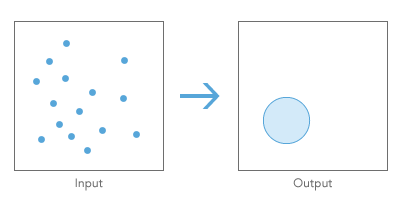

The [Standard Distance Tool](http://pro.arcgis.com/en/pro-app/tool-reference/spatial-statistics/h-how-standard-distance-spatial-statistic-works.htm) works by measuring the compactness of a distribution and provides a single value representing the dispersion of features around the center. 

The value is a distance, so the compactness of a set of features can be represented on a map by drawing a circle or a sphere with the radius equal to the standard distance value. The Standard Distance tool creates a circle polygon or a multipatch sphere if your data is z enabled.

In [25]:
crash_type_summary_stats = pd.read_csv(os.path.join(workspace_dir, "crash_type_summary_stats.csv"))

data = crashes_fars_sedf
type_field = "Cause"

top_types_dict = {
    "Rank_1":{},
    "Rank_2":{},
    "Rank_3":{},
    "Rank_4":{},
    "Rank_5":{},
}

print("Producing layers for most clustered accident types...")

top_causes = crash_type_summary_stats.sort_values(by='Std. Distance Mean').head()['Cause'].tolist()

# Produce data for the top five most clustered accident types
for ix, top_cause in enumerate(top_causes):
    print("\nStep {0} of {1}: Measuring spatial distribution of '{2}' accidents...".format(str(ix+1), 
                                                                                           str(len(top_causes)), 
                                                                                           top_cause))
    cause_df = data.loc[data[type_field] == top_cause]
    
    crashes_fc = cause_df.spatial.to_featureclass(os.path.join(workspace_fgdb, "ranked{0}_acctype_fc".format(str(ix+1))))

    # Run Density-based Clustering
    print("\tRunning Density-based Clustering (HDBSCAN with 3 minimum features per cluster)...".format(str(ix+1)))
    output_clusters_path = "{0}//{1}_HDBSCAN".format(workspace_fgdb, "ranked{0}_acctype_hdbscan_fc".format(str(ix+1)))
    hdbscan_result = arcpy.stats.DensityBasedClustering(crashes_fc, output_clusters_path, "HDBSCAN", 5)
    hdbscan_sedf = pd.DataFrame.spatial.from_featureclass(hdbscan_result.getOutput(0))

    cluster_count = hdbscan_sedf[hdbscan_sedf['CLUSTER_ID']!=-1].shape[0]
    noise_count = hdbscan_sedf[hdbscan_sedf['CLUSTER_ID']==-1].shape[0]


    # Parse out accidents that were members of a cluster and write to feature class
    clusters_fc = hdbscan_sedf[hdbscan_sedf['CLUSTER_ID']!=-1].spatial.to_featureclass(os.path.join(workspace_fgdb, "ranked{0}_acctype_clusters_fc".format(str(ix+1))))

    print("\tRunning Standard Distance measurement...")
    output_stddistance_path = "{0}//{1}".format(workspace_fgdb, "ranked{0}_acctype_stddistance_fc".format(str(ix+1)))
    stddistance_result = arcpy.stats.StandardDistance(clusters_fc, output_stddistance_path, Case_Field='CLUSTER_ID')
    stddistance_sedf = pd.DataFrame.spatial.from_featureclass(stddistance_result.getOutput(0))
    
    top_types_dict["Rank_{0}".format(str(ix+1))]["cause_name"] = top_cause
    top_types_dict["Rank_{0}".format(str(ix+1))]["accidents_df"] = cause_df
    top_types_dict["Rank_{0}".format(str(ix+1))]["accidents_fc"] = crashes_fc
    top_types_dict["Rank_{0}".format(str(ix+1))]["hdbscan_df"] = hdbscan_sedf
    top_types_dict["Rank_{0}".format(str(ix+1))]["clustered_df"] = hdbscan_sedf[hdbscan_sedf['CLUSTER_ID']!=-1]
    top_types_dict["Rank_{0}".format(str(ix+1))]["noise_df"] = hdbscan_sedf[hdbscan_sedf['CLUSTER_ID']!=-1]
    top_types_dict["Rank_{0}".format(str(ix+1))]["stddistance_circles_df"] = stddistance_sedf

Producing layers for most clustered accident types...

Step 1 of 5: Measuring spatial distribution of 'Motor Vehicle in Transport' accidents...
	Running Density-based Clustering (HDBSCAN with 3 minimum features per cluster)...
	Running Standard Distance measurement...

Step 2 of 5: Measuring spatial distribution of 'Pedestrian' accidents...
	Running Density-based Clustering (HDBSCAN with 3 minimum features per cluster)...
	Running Standard Distance measurement...

Step 3 of 5: Measuring spatial distribution of 'Tree (Standing Only)' accidents...
	Running Density-based Clustering (HDBSCAN with 3 minimum features per cluster)...
	Running Standard Distance measurement...

Step 4 of 5: Measuring spatial distribution of 'Guardrail Face' accidents...
	Running Density-based Clustering (HDBSCAN with 3 minimum features per cluster)...
	Running Standard Distance measurement...

Step 5 of 5: Measuring spatial distribution of 'Parked Motor Vehicle (Not in Transport)' accidents...
	Running Density-

In [26]:
def get_crash_type_rank_map(rank, top_types_dict, location='Maryland', basemap='gray', print_title=True, use_ipython_display=False):
    key = "Rank_{0}".format(str(rank))
    rank_map = gis.map(location)
    rank_map.basemap = basemap
    top_types_dict[key]["stddistance_circles_df"].spatial.plot(map_widget=rank_map)
    top_types_dict[key]["clustered_df"].spatial.plot(map_widget=rank_map, renderer_type='u', col='COLOR_ID')
    if print_title:
        print("Rank {0} Spatial Clustering".format(str(rank)))
        print("Accident Type: "+top_types_dict[key]["cause_name"])
    if use_ipython_display:
        display(rank_map)
    return rank_map

In [28]:
for i in range(5, 0, -1):
    get_crash_type_rank_map(i, top_types_dict, use_ipython_display=True)

Rank 5 Spatial Clustering
Accident Type: Parked Motor Vehicle (Not in Transport)


MapView(layout=Layout(height='400px', width='100%'))

Rank 4 Spatial Clustering
Accident Type: Guardrail Face


MapView(layout=Layout(height='400px', width='100%'))

Rank 3 Spatial Clustering
Accident Type: Tree (Standing Only)


MapView(layout=Layout(height='400px', width='100%'))

Rank 2 Spatial Clustering
Accident Type: Pedestrian


MapView(layout=Layout(height='400px', width='100%'))

Rank 1 Spatial Clustering
Accident Type: Motor Vehicle in Transport


MapView(layout=Layout(height='400px', width='100%'))

<span>Rank 5: Parked Motor Vehicle (Not in Transport)
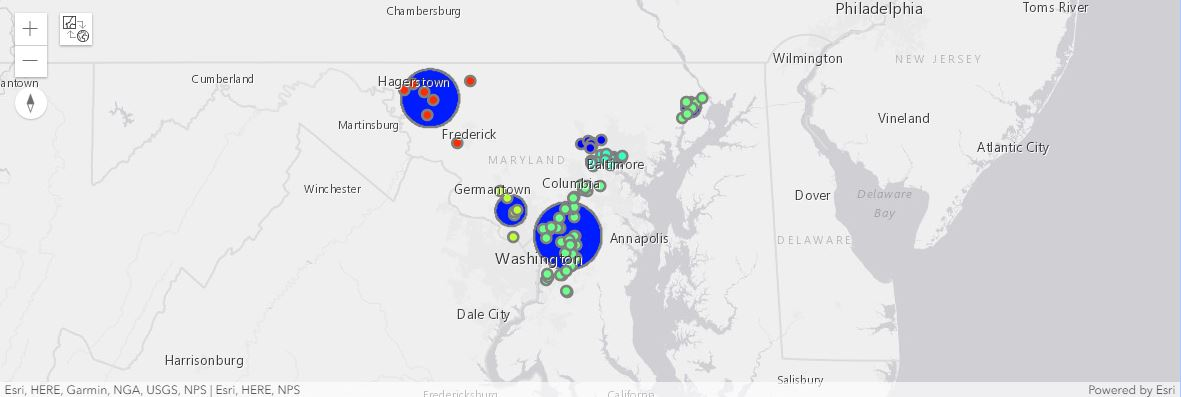

<span>Rank 4: Guardrail Face
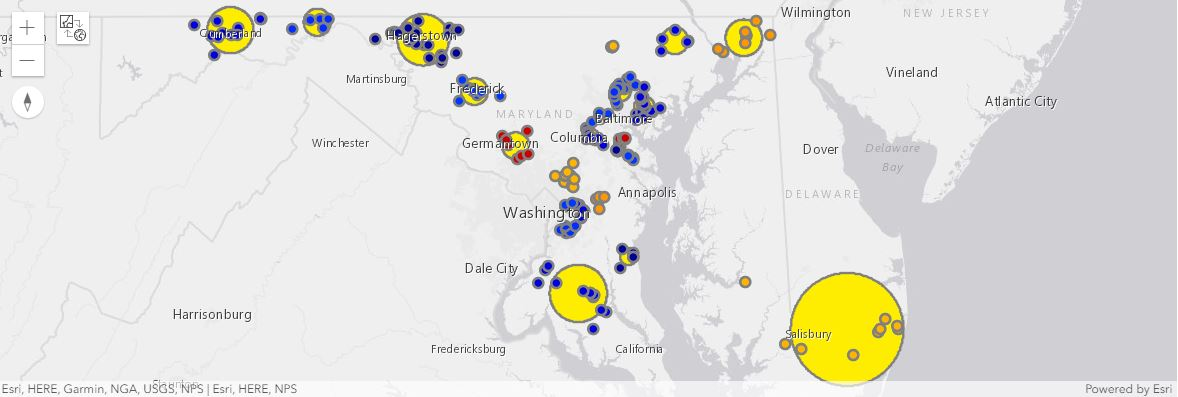

<span>Rank 3:Tree (Standing Only)
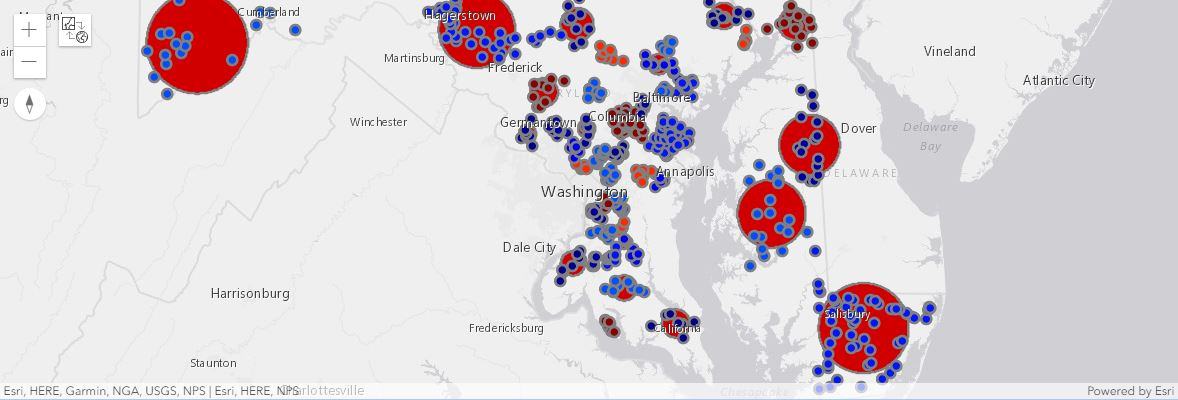

<span>Rank 2: Pedestrian
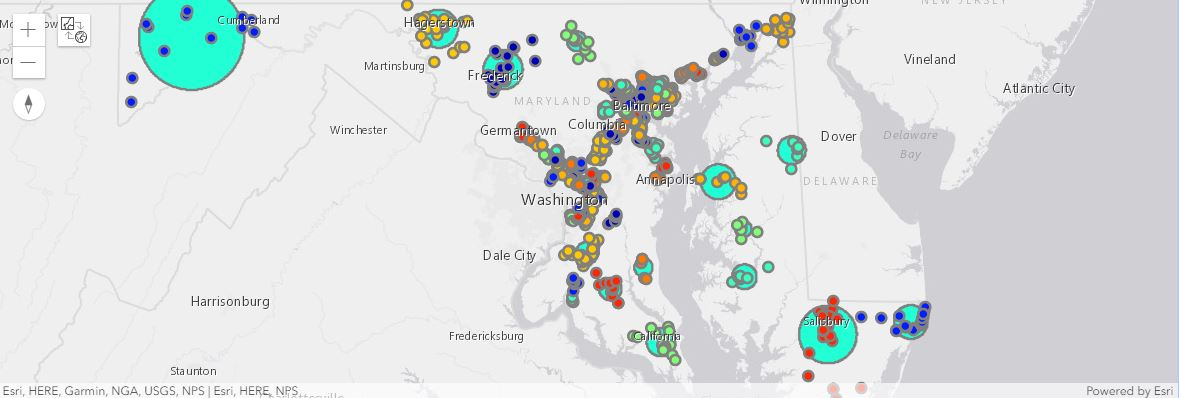

<span>Rank 1: Motor Vehicle in Transport
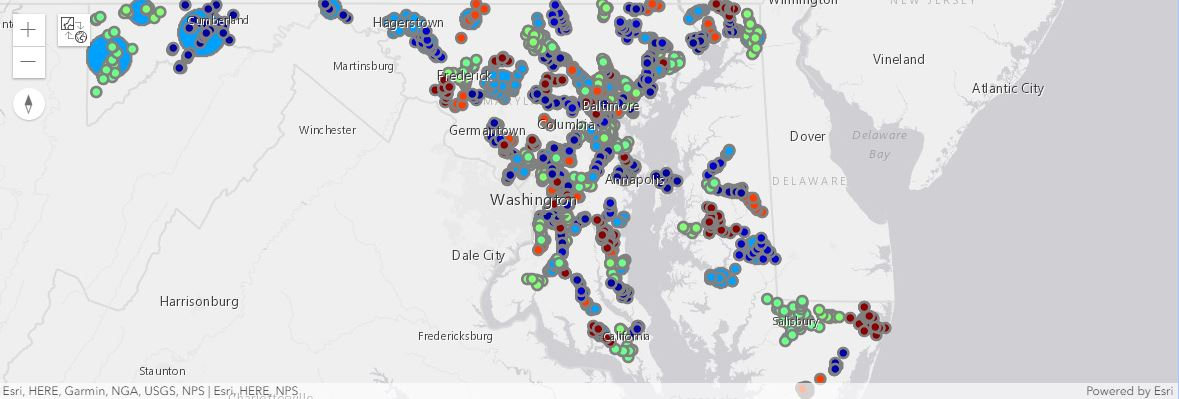

In [ ]:
crash_type_summary_stats.sort_values(by='Std. Distance Mean').head()

## <span style="color:Green">Step 1 Takeaway: </span>
### <span>Accident types: "Motor Vehicle in Transport", "Pedestrian", and "Tree (Standing Only)" are the most spatially clustered types of accidents in Maryland.</span>
### <span>Proposal: Network Screening should focus on these three types of accidents first.</span>

# <span style="color:Purple">Step 2: Network Screening</span>
## <span>A) Assign Crashes to Roads and determine Crash Rates (Accidents by Traffic Volume)</span>
## <span>B) Use Transportation Engineering Regression Models to Find Roads with High Potential for Accident Reduction</span>

http://spfclearinghouse.org/

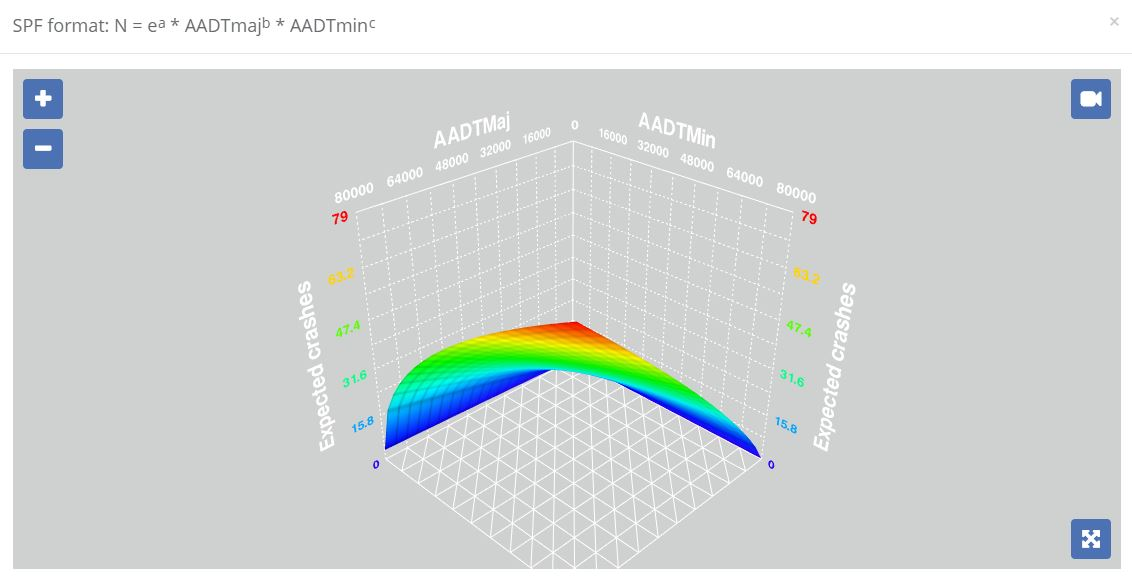

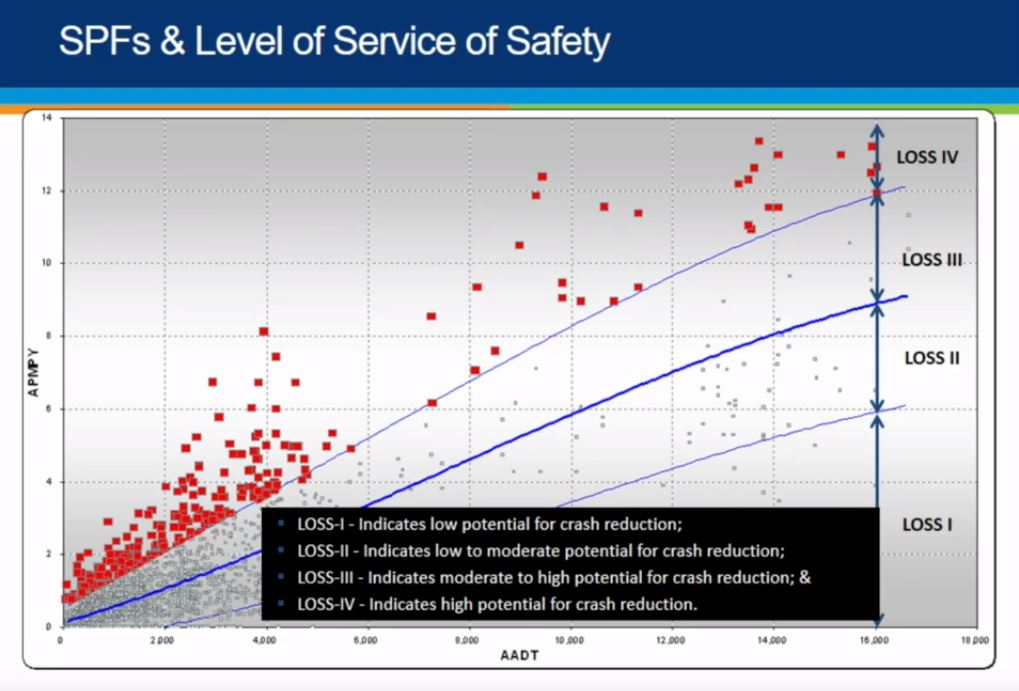

## <span>A) Assign Crashes to Roads and determine Crash Rates (Accidents by Traffic Volume)</span>

In [ ]:
segmented_routes_map = gis.map("Maryland")
segmented_routes_map.basemap = 'gray'
segmented_routes_map.add_layer(routes_fhwans_mvtcrashes_item)
# segmented_routes_map

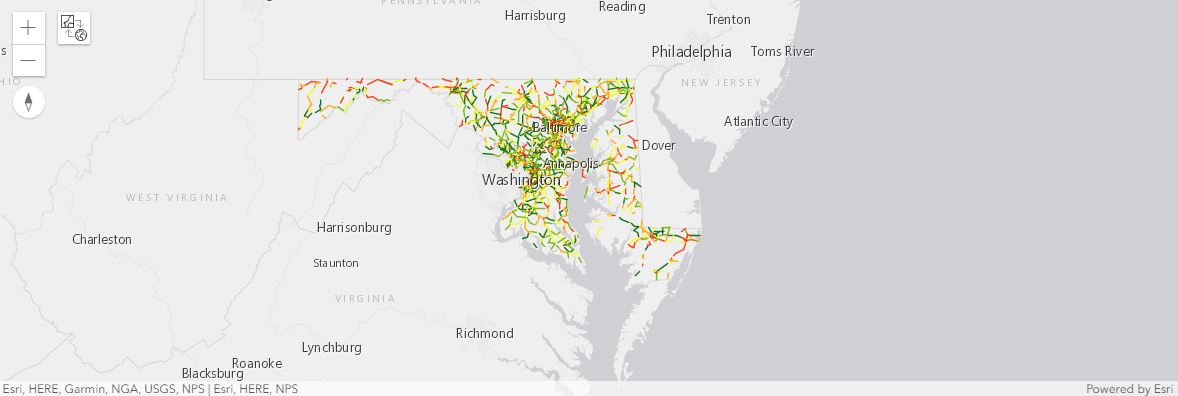

In [ ]:
segmented_routes_map = gis.map("Maryland")
segmented_routes_map.basemap = 'gray'
segmented_routes_map.add_layer(routes_fhwans_pedestriancrashes_item)
# segmented_routes_map

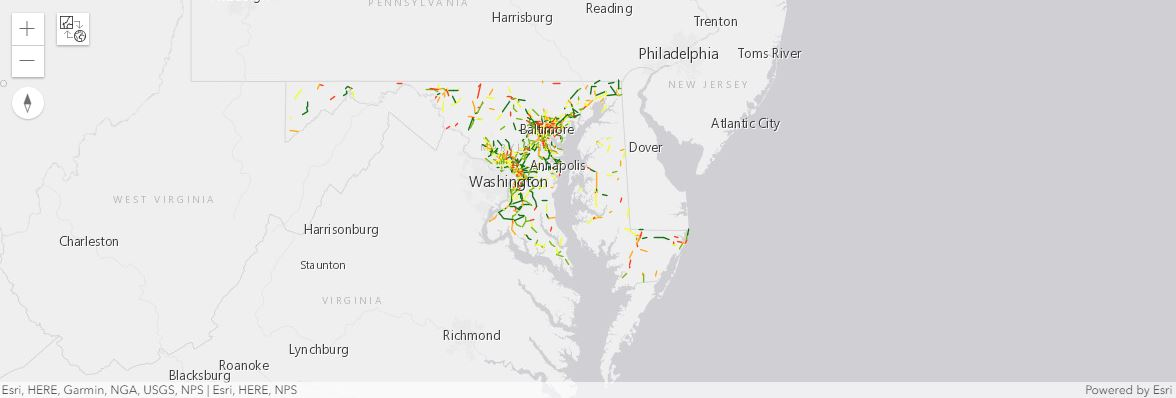

In [ ]:
segmented_routes_map = gis.map("Maryland")
segmented_routes_map.basemap = 'gray'
segmented_routes_map.add_layer(routes_fhwans_treecrashes_item)
# segmented_routes_map

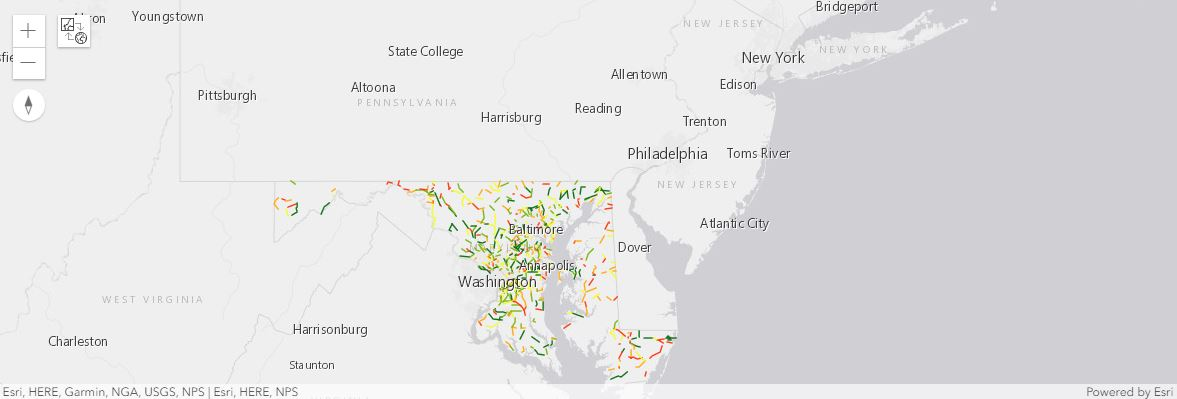

## <span>B) Use Transportation Engineering Regression Models to Find Roads with High Potential for Accident Reduction</span>
### Select LOSS IV Road Segments for Each Type of Accident

In [ ]:
# sns.lmplot(x="segmentoutput_usrap_avg_aadt_x", y="segmentoutput_crash_density", data=all_segments_df, hue="segmentoutput_usrap_roadway_typ", col="Cause", fit_reg=True)
sns.lmplot(x="segmentoutput_usrap_avg_aadt_x", y="segmentoutput_crash_density", data=all_segments_df, hue="Cause", fit_reg=True)
sns.lmplot(x="segmentoutput_usrap_avg_aadt_x", y="segmentoutput_crash_density", data=all_segments_df, col="Cause", fit_reg=True)

In [ ]:
loss4_mvt_map = gis.map("Maryland")
loss4_mvt_map.basemap = 'gray'
loss4_mvt_map.add_layer(loss4_mvt_item)
# display(loss4_mvt_map)
loss4_mvt_map.extent = loss4_mvt_item.extent

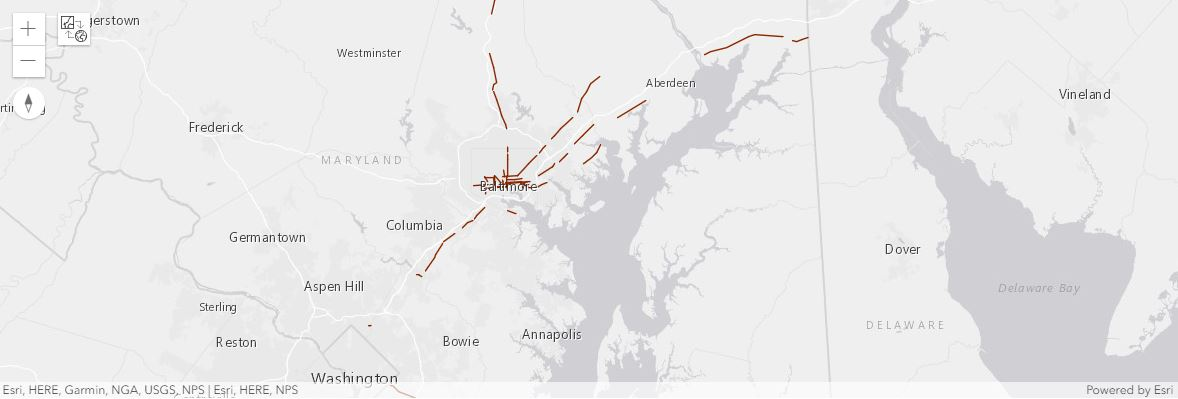

In [ ]:
loss4_ped_map = gis.map("Maryland")
loss4_ped_map.basemap = 'gray'
loss4_ped_map.add_layer(loss4_ped_item)
# display(loss4_ped_map)
loss4_ped_map.extent = loss4_ped_item.extent

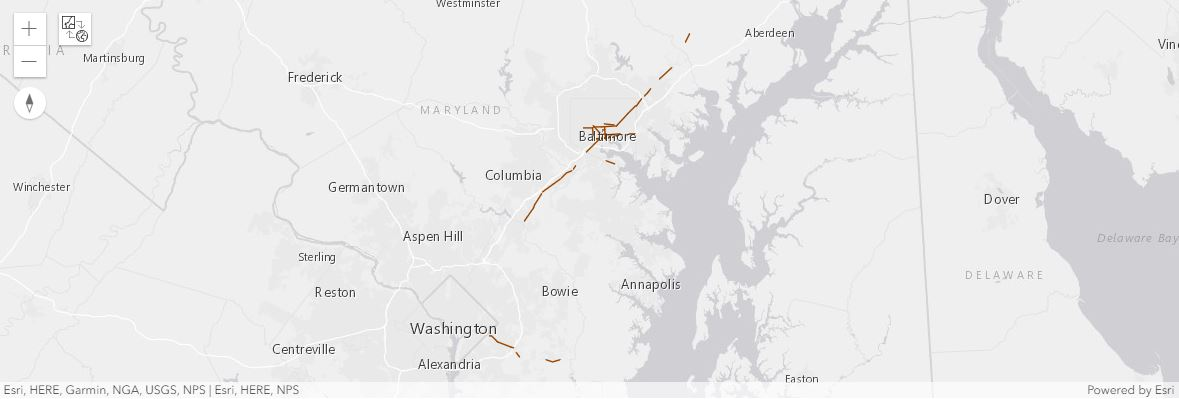

In [ ]:
loss4_tree_map = gis.map("Maryland")
loss4_tree_map.basemap = 'gray'
loss4_tree_map.add_layer(loss4_tree_item)
# display(loss4_tree_map)
loss4_tree_map.extent = loss4_tree_item.extent

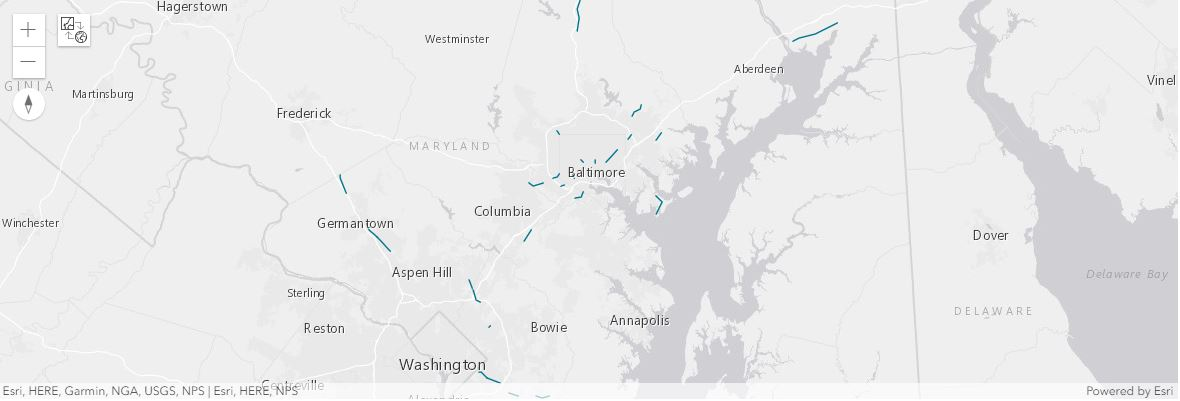

## <span style="color:Green">Step 2 Takeaways: </span>
### <span>The segments shown above for each crash type are the segments with the highest potential for accident reduction.</span>
### <span>Proposal: Countermeasure selection should focus on these segments for the specified accident types.</span>

# <span style="color:Purple">Step 3: Diagnosis and Countermeasure Selection</span>
## <span>A) Find applicable roadway countermeasures </span>
## <span>B) Perform cost-benefit analysis to recommend solution</span>

http://www.cmfclearinghouse.org/

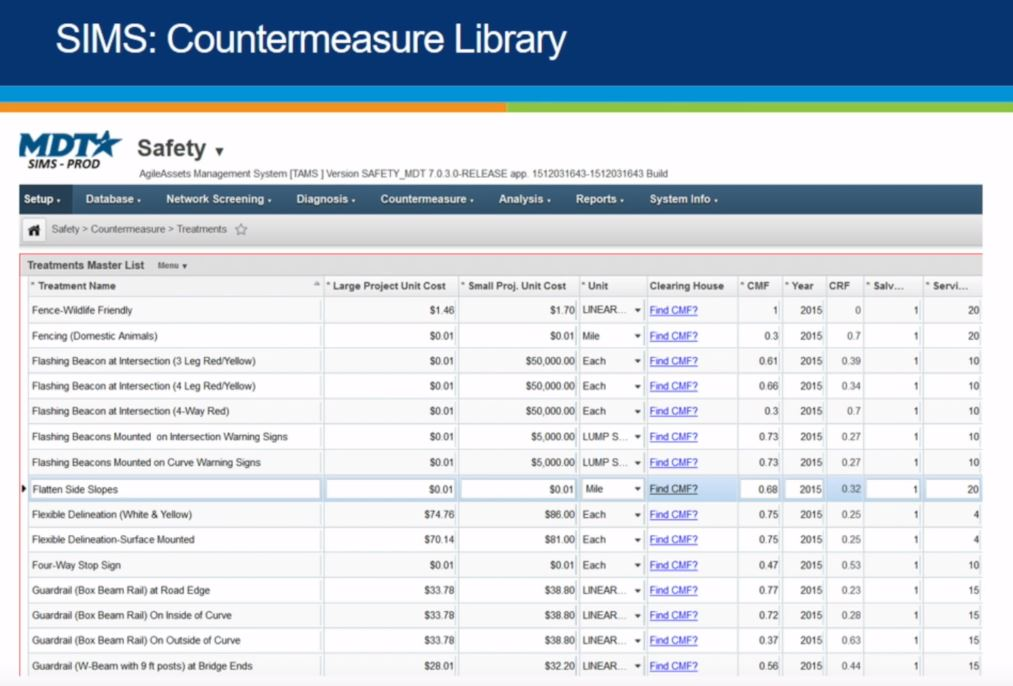

## How do we apply the right one of these...

In [ ]:
cmf_df.sample(n=5)

## ... to each of these?

In [ ]:
loss4_tree_map = gis.map("Maryland")
loss4_tree_map.basemap = 'gray'
loss4_tree_map.add_layer(loss4_tree_item)
# display(loss4_tree_map)
loss4_tree_map.extent = loss4_tree_item.extent

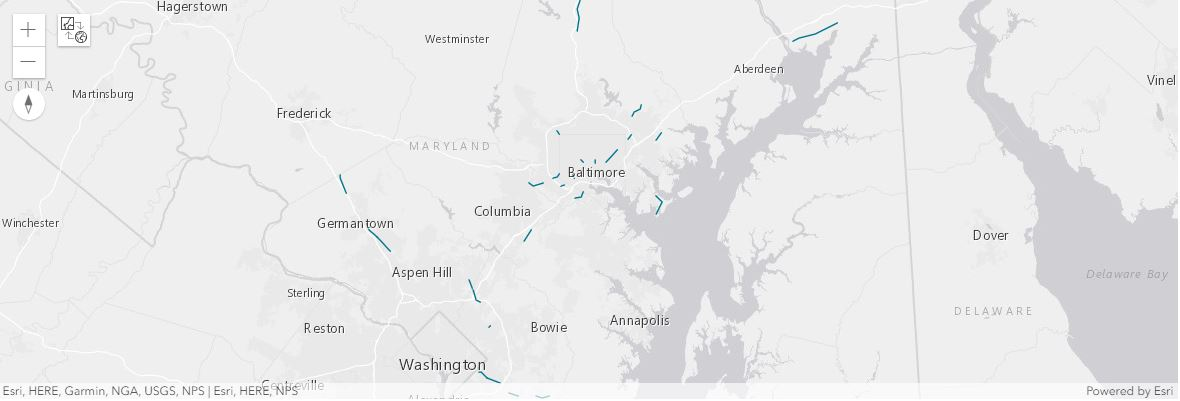

## <span>A) Find applicable roadway countermeasures </span>

In [32]:
limit_to_state_countermeasures = False

limit_to_applicable_area_type = True

limit_to_applicable_lane_count = True

limit_to_applicable_division_type = True

segment_state_field = "State"
segment_area_type_field = "SegmentOutput_USRAP_AREA_TYPE".lower()
segment_lane_count_field = "SegmentOutput_USRAP_LANES_x".lower()
segment_median_field = "SegmentOutput_USRAP_MEDIAN".lower()
segment_crash_type_field = "Crash_Type".lower()
segment_traffic_volume_field = "SegmentOutput_USRAP_AVG_AADT_x".lower()
segment_crash_rate_field = "SegmentOutput_CRASH_RATE".lower()
segment_crash_density_field = "SegmentOutput_CRASH_DENSITY_RIS".lower()
segment_avg_crash_field = "SegmentOutput_AVG_CRASH".lower()

# Genreal countermeasure descriptions
countermeasures_state_field = "State"
countermeasures_area_type_field = "Area Type"
countermeasures_lane_count_field = "Number of Lanes"
countermeasures_median_field = "Roadway Division Type"

# Categories to determine crash type
countermeasures_id_field = "CMF ID"
countermeasures_category_field = "Countermeasure Category"
countermeasures_subcategory_field = "Countermeasure Subcategory"
countermeasures_name_field = "Countermeasure"
countermeasures_crash_type = "Crash Type"

# Categories to determine traffic volume
countermeasures_max_volume_field = "Maximum Traffic Volume (non-intersection)"
countermeasures_min_volume_field = "Minimum Traffic Volume (non-intersection)"

# Categories to determine effectiveness of countermeasure
countermeasures_ranking_field = "Star Quality Rating"
countermeasures_cmf_field = "CMF"

def get_applicable_state_countermeasure_values(state_value, countermeasures_df, countermeasures_state_field=countermeasures_state_field):
    applicable_value_list = [item for item in countermeasures_df[countermeasures_state_field].unique().tolist() if state_value in str(item).split(",") and isinstance(item, str)]
    return applicable_value_list

def get_applicable_area_type_countermeasure_values(area_type_value, countermeasures_df, countermeasures_area_type_field=countermeasures_area_type_field):
    wildcard_values = ["Not specified", "Not Specified", "All", float("nan")]
    
    applicable_value_list = [item for item in countermeasures_df[countermeasures_area_type_field].unique().tolist() if area_type_value.lower() in str(item).lower().split(" ")]
    applicable_value_list.extend(wildcard_values)
    
    return applicable_value_list

def get_applicable_lane_countermeasure_values(number_of_lanes, countermeasures_df, countermeasures_lanes_field=countermeasures_lane_count_field, include_date_vals=True):
    
    single_lane_wildcard_vals = [float("nan"), "Single", "one"]
    multilane_wildcard_vals = [float("nan"), "Multilane", "Var.", "multi", "multilane", "Multi"]
    
    if number_of_lanes == 1:
        applicable_value_list = single_lane_wildcard_vals
        appended_list = [item for item in countermeasures_df[countermeasures_lanes_field].unique().tolist() if "1" in str(item).split(" ")]
        applicable_value_list.extend(appended_list)
        
    elif number_of_lanes > 1:
        applicable_value_list = multilane_wildcard_vals
        appended_list = [item for item in countermeasures_df[countermeasures_lanes_field].unique().tolist() if str(number_of_lanes) in str(item).split(" ")]
        applicable_value_list.extend(appended_list)
    
    if include_date_vals:
        applicable_value_list.extend([item for item in countermeasures_df[countermeasures_lanes_field].unique().tolist() if isinstance(item, datetime.date)])
        
    return applicable_value_list

def get_applicable_median_countermeasure_values(segment_value, countermeasures_df, countermeasures_median_field=countermeasures_median_field, include_twltl=True):
    wildcard_values = [float("nan"), "All"]
    if include_twltl:
        wildcard_values.append("Divided by TWLTL")
    
    if segment_value == "Undivided Roadway":
        applicable_value_list = ["Undivided"]
    elif segment_value == "Divided Roadway":
        applicable_value_list = ["Divided", "Divided by Median"]
    else:
        print("WARNING: An unexpected segment median value was passed. Please confirm that this segment is has a median value of 'Undivided Roadway' or 'Divided Roadway'.")
        applicable_value_list = []
    
    applicable_value_list.extend(wildcard_values)
    return applicable_value_list

def get_applicable_crash_type_countermeasure_values(segment_value, 
                                                    countermeasures_df, 
                                                    countermeasures_category_field=countermeasures_category_field, 
                                                    countermeasures_subcategory_field=countermeasures_subcategory_field):
    wildcard_values = []
    
    if segment_value == "Motor Vehicle in Transport":
        applicable_value_list = ["Roadway", "Access management", "Signs", "Advanced technology and ITS", "Delineation", "Speed management", "Highway lighting", "Interchange design"]
        
    elif segment_value == "Pedestrian":
        applicable_value_list = ["Pedestrian", "Advanced technology and ITS"]
        
    elif segment_value == "Tree (Standing Only)":
        applicable_value_list = ["Shoulder treatments", "Roadside", "Alignment", "Delineation", "Speed management", "Highway lighting"]
        
    else:
        print("WARNING: An unexpected segment crash type value was passed. Please confirm that this segment can be processed.")
        applicable_value_list = []
    
    applicable_value_list.extend(wildcard_values)
    return applicable_value_list

def get_applicable_countermeasures_for_segment(segment_record, applicable_countermeasures_df, 
                                               
                                               segment_state_field = segment_state_field,
                                               segment_area_type_field = segment_area_type_field,
                                               segment_lane_count_field = segment_lane_count_field,
                                               segment_median_field = segment_median_field,
                                               segment_crash_type_field = segment_crash_type_field,
                                               segment_traffic_volume_field = segment_traffic_volume_field,
                                               
                                               countermeasures_state_field=countermeasures_state_field,
                                               countermeasures_area_type_field=countermeasures_area_type_field,
                                               countermeasures_lane_count_field=countermeasures_lane_count_field,
                                               countermeasures_median_field=countermeasures_median_field,
                                               countermeasures_category_field=countermeasures_category_field,
                                               
                                               limit_to_state_countermeasures=False, 
                                               limit_to_applicable_area_type=True, 
                                               limit_to_applicable_lane_count=True, 
                                               limit_to_applicable_division_type=True,
                                               limit_to_applicable_crash_type=True,
                                               
                                               verbose=True
                                              ):
    
    if isinstance(segment_record, pd.DataFrame):
        segment_record = segment_record.iloc[0]
    
    if limit_to_state_countermeasures:
        
        if verbose: print("\nDetermining state limitations...")
        pre_count = applicable_countermeasures_df.shape[0]
        applicable_countermeasures_df = applicable_countermeasures_df.loc[applicable_countermeasures_df[countermeasures_state_field].isin(get_applicable_state_countermeasure_values(segment_record[segment_state_field], applicable_countermeasures_df))]
        post_count = applicable_countermeasures_df.shape[0]
        if verbose: print("{0} of {1} total countermeasures applicable based on state.".format(str(post_count), str(pre_count)))
        
    if limit_to_applicable_area_type:
        
        if verbose: print("\nDetermining applicable area limitations...")
        pre_count = applicable_countermeasures_df.shape[0]
        applicable_countermeasures_df = applicable_countermeasures_df.loc[applicable_countermeasures_df[countermeasures_area_type_field].isin(get_applicable_area_type_countermeasure_values(segment_record[segment_area_type_field], applicable_countermeasures_df))]
        post_count = applicable_countermeasures_df.shape[0]
        if verbose: print("{0} of {1} total countermeasures applicable based on area type.".format(str(post_count), str(pre_count)))  
        
    if limit_to_applicable_lane_count:
        
        if verbose: print("\nDetermining applicable lane count limitations...")
        pre_count = applicable_countermeasures_df.shape[0]
        applicable_countermeasures_df = applicable_countermeasures_df.loc[applicable_countermeasures_df[countermeasures_lane_count_field].isin(get_applicable_lane_countermeasure_values(segment_record[segment_lane_count_field], applicable_countermeasures_df))]
        post_count = applicable_countermeasures_df.shape[0]
        if verbose: print("{0} of {1} total countermeasures applicable based on lane count.".format(str(post_count), str(pre_count)))
        
    if limit_to_applicable_division_type:
        
        if verbose: print("\nDetermining applicable road division limitations...")
        pre_count = applicable_countermeasures_df.shape[0]
        applicable_countermeasures_df = applicable_countermeasures_df.loc[applicable_countermeasures_df[countermeasures_median_field].isin(get_applicable_median_countermeasure_values(segment_record[segment_median_field], applicable_countermeasures_df))]
        post_count = applicable_countermeasures_df.shape[0]
        if verbose: print("{0} of {1} total countermeasures applicable based on road division.".format(str(post_count), str(pre_count)))     
        
    if limit_to_applicable_crash_type:
        
        if verbose: print("\nDetermining applicable crash type limitations...")
        pre_count = applicable_countermeasures_df.shape[0]
        applicable_countermeasures_df = applicable_countermeasures_df.loc[applicable_countermeasures_df[countermeasures_category_field].isin(get_applicable_crash_type_countermeasure_values(segment_record[segment_crash_type_field], applicable_countermeasures_df))]
        post_count = applicable_countermeasures_df.shape[0]
        if verbose: print("{0} of {1} total countermeasures applicable based on crash type.".format(str(post_count), str(pre_count)))   
    
#     print("\n<<< {0} total countermeasures applicable based on segment characteristics. >>>".format(str(post_count)))
    
    return applicable_countermeasures_df

def get_segment_map_and_countermeasures(segment_iloc, segments_df, countermeasures_df, 
                                        map_location="Maryland", basemap='gray', colors='Dark2', line_width=0.5, symbol_style='s',
                                        limit_to_state_countermeasures=False, 
                                        limit_to_applicable_area_type=True, 
                                        limit_to_applicable_lane_count=True, 
                                        limit_to_applicable_division_type=True,
                                        limit_to_applicable_crash_type=True,
                                        limit_to_applicable_cmf_above_zero=True,
                                        filter_pedestrian_cmfs=False,
                                        display_output=True, num_of_cmfs_to_display=2, 
                                        only_show_summary_segment_fields=True, only_show_summary_cmf_fields=True, 
                                        sort_cmfs=True, sort_priority="Star Rating", 
                                        verbose=False):
        
    summary_segment_fields = [segment_area_type_field, 
                              segment_crash_type_field, 
                              segment_lane_count_field, 
                              segment_median_field, 
                              segment_traffic_volume_field,
                              segment_avg_crash_field,
                              segment_crash_rate_field]
    
    summary_cmf_fields = [countermeasures_id_field, 
                          countermeasures_category_field, countermeasures_name_field, 
                          countermeasures_ranking_field, countermeasures_cmf_field, countermeasures_webpage_field]
    
    segment_df = segments_df.iloc[segment_iloc: segment_iloc+1]
    
    web_map = gis.map(map_location)
    web_map.basemap = basemap
    segment_df.spatial.plot(map_widget=web_map, cmap=colors, line_width=line_width, symbol_style=symbol_style)
    
    if display_output:
        print("\nSegment:")
        display(segment_df[summary_segment_fields], web_map)
    
    applicable_countermeasures_df = get_applicable_countermeasures_for_segment(segment_df, countermeasures_df,
                                                                               limit_to_state_countermeasures=limit_to_state_countermeasures, 
                                                                               limit_to_applicable_area_type=limit_to_applicable_area_type, 
                                                                               limit_to_applicable_lane_count=limit_to_applicable_lane_count, 
                                                                               limit_to_applicable_division_type=limit_to_applicable_division_type,
                                                                               limit_to_applicable_crash_type=limit_to_applicable_crash_type,
                                                                               verbose=verbose)
    if limit_to_applicable_cmf_above_zero:
        applicable_countermeasures_df = applicable_countermeasures_df.loc[applicable_countermeasures_df[countermeasures_cmf_field] > 0]
        
    if filter_pedestrian_cmfs:
        applicable_countermeasures_df = applicable_countermeasures_df.loc[applicable_countermeasures_df[countermeasures_category_field]=="Pedestrians"]
    
    if sort_cmfs:
        if sort_priority == "Star Rating":
            applicable_countermeasures_df = applicable_countermeasures_df.sort_values([countermeasures_ranking_field, countermeasures_cmf_field], ascending=[False, True])
        elif sort_priority == "CMF":
            applicable_countermeasures_df = applicable_countermeasures_df.sort_values([countermeasures_cmf_field, countermeasures_ranking_field], ascending=[True, False])
        else:
            print("Select a sorting priority.")
        
    def make_clickable(val):
        # target _blank to open new window
        return '<a target="_blank" href="{}">{}</a>'.format(val, val)
    
    if display_output:
        print("\nTop {0} selected countermeasures for segment:".format(num_of_cmfs_to_display))
        display(applicable_countermeasures_df.head(num_of_cmfs_to_display)[summary_cmf_fields].style.format({countermeasures_webpage_field: make_clickable}))
    
    return web_map, segment_df, applicable_countermeasures_df

In [34]:
# Test function: pass an index number corresponding to the segment ID we want to get a map for and applicable countermeasures
web_map, segment_df, applicable_cmfs_df = get_segment_map_and_countermeasures(0, loss4_ped_df.loc[loss4_ped_df['shape__length'] < 2000], cmf_df, basemap='gray', colors='cool', line_width=8, symbol_style="s", limit_to_applicable_crash_type=False, filter_pedestrian_cmfs=True)
web_map.basemap = 'hybrid'
web_map.extent = {'spatialReference': {'latestWkid': 3857, 'wkid': 102100},
 'xmin': -8530480.599258441,
 'ymin': 4762438.195929131,
 'xmax': -8526336.279130995,
 'ymax': 4763393.658782721}
web_map.add_layer(crashes_maryland_item)
web_map.legend = True


Segment:


,segmentoutput_usrap_area_type,crash_type,segmentoutput_usrap_lanes_x,segmentoutput_usrap_median,segmentoutput_usrap_avg_aadt_x,segmentoutput_avg_crash,segmentoutput_crash_rate
9,Urban,Pedestrian,4,Undivided Roadway,30340.2,98.4,270.18074


MapView(layout=Layout(height='400px', width='100%'))


Top 2 selected countermeasures for segment:


,CMF ID,Countermeasure Category,Countermeasure,Star Quality Rating,CMF,CMF Webpage
1539,2911,Pedestrians,Install a pedestrian hybrid beacon (PHB or HAWK),4,0.712,http://www.cmfclearinghouse.org/detail.cfm?facid=2911
1550,2922,Pedestrians,Install a pedestrian hybrid beacon (PHB or HAWK),3,0.309,http://www.cmfclearinghouse.org/detail.cfm?facid=2922
